In [11]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib import cycler
from IPython.display import clear_output

# Prometheus server URL
prometheus_url = 'http://localhost:9090'  

cpu_query = 'sum(irate(node_cpu_seconds_total{instance="node-exporter:9100", job="node_exporter", mode!="idle"}[5m])) / scalar(count(count(node_cpu_seconds_total{instance="node-exporter:9100", job="node_exporter"}) by (cpu)))'
ram_query = 'node_memory_MemAvailable_bytes{instance="node-exporter:9100", job="node_exporter"} / node_memory_MemTotal_bytes{instance="node-exporter:9100", job="node_exporter"}'


def fetch_data(query, start, end):
    response = requests.get(f'{prometheus_url}/api/v1/query_range', params={
        'query': query,
        'start': start,
        'end': end,
        'step': '1s'
    })
    response.raise_for_status()  
    results = response.json()['data']['result']
    print(f"Data for interval {start} to {end}: {results}")
    return results

def process_data(data):
    if not data:
        print("No data returned from Prometheus.")
        return [], []
    timestamps = [pd.to_datetime(point[0], unit='s') for point in data[0]['values']]
    values = [float(point[1]) for point in data[0]['values']]
    return timestamps, values

def normalize_timestamps(timestamps):
    start_time = timestamps[0] if timestamps else None
    return [(ts - start_time).total_seconds() for ts in timestamps], start_time

def plot_grouped_data(data_groups, ylabel, title, output_file):
    plt.figure(figsize=(14, 7))

    plt.rc('axes', prop_cycle=(cycler('color', plt.cm.tab20.colors)))

    for normalized_timestamps, values, label in data_groups:
        plt.plot(normalized_timestamps, values, label=label)

    plt.xlabel('Seconds from Start')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()

    os.makedirs(os.path.dirname(output_file), exist_ok=True)

    plt.savefig(output_file, dpi=300)
    plt.show()

def plot_avg_data(values_dict, data_types, ylabel, title, output_file, variable_name, is_throughput=False):
    plt.figure(figsize=(14, 7))

    plt.rc('axes', prop_cycle=(cycler('color', plt.cm.tab20.colors)))

    if is_throughput:
        all_throughput_values = [value for sublist in values_dict.values() for value in sublist if value is not None]
        max_throughput = max(all_throughput_values)
        if max_throughput > 1000000:
            throughput_unit = "MB/s"
            throughput_scale = 1 / (1024 * 1024)
        elif max_throughput > 1000:
            throughput_unit = "KB/s"
            throughput_scale = 1 / 1024
        else:
            throughput_unit = "B/s"
            throughput_scale = 1
        
        for key in values_dict:
            values_dict[key] = [value * throughput_scale if value is not None else None for value in values_dict[key]]
        
        ylabel = f'Average Throughput ({throughput_unit})'

    for key, values in values_dict.items():
        plt.plot(data_types, [value if value is not None else 0 for value in values], marker='o', label=key)
    
    for key, values in values_dict.items():
        for i, value in enumerate(values):
            if value is not None:
                plt.text(data_types[i], value, f'{value:.2f}', ha='center', va='bottom')

    plt.xlabel(variable_name)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()

    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    plt.savefig(output_file, dpi=300)
    plt.show()



def compare_performance(test_cases):
    results = []
    for case in test_cases:
        data_type_name, http_version, parallel_count, num_repeats, network_latency = case
        route = f"data/performance/{data_type_name}_{http_version}_{parallel_count}_{num_repeats}_{network_latency}ms.sh"

        if not os.path.isfile(route):
            print(f"File {route} does not exist.")
            continue

        df = pd.read_csv(route)

        start_time = df.loc[df.index[0], 'start_time']
        end_time = df.loc[df.index[0], 'end_time']
        total_average_latency = df.loc[df.index[0], 'total_average_latency']
        total_average_throughput = df.loc[df.index[0], 'total_average_throughput']

        results.append({
            'data_type_name': data_type_name,
            'http_version': http_version,
            'parallel_count': parallel_count,
            'num_repeats': num_repeats,
            'network_latency': network_latency,
            'start_time': start_time,
            'end_time': end_time,
            'total_average_latency': total_average_latency,
            'total_average_throughput': total_average_throughput
        })

    time_intervals = [(result['start_time'], result['end_time']) for result in results]

    return results, time_intervals


def perform_comparison(test_cases, variable_name, second_variable_name, variable1_list, variable2_list):
    results, time_intervals = compare_performance(test_cases)

    network_latencys = variable1_list.split('_')
    cpu_data_groups = []
    ram_data_groups = []
    avg_latency = {http_version: [None] * len(network_latencys) for http_version in set(case[1] for case in test_cases)}
    avg_throughput = {http_version: [None] * len(network_latencys) for http_version in set(case[1] for case in test_cases)}
    avg_cpu_usage = {http_version: [None] * len(network_latencys) for http_version in set(case[1] for case in test_cases)}
    avg_ram_usage = {http_version: [None] * len(network_latencys) for http_version in set(case[1] for case in test_cases)}

    for result in results:
        network_latency = result['network_latency']
        http_version = result['http_version']
        start_time = result['start_time']
        end_time = result['end_time']

        index = network_latencys.index(str(network_latency))
        
        avg_latency[http_version][index] = result['total_average_latency']
        avg_throughput[http_version][index] = result['total_average_throughput']

        # Fetch data
        cpu_data = fetch_data(cpu_query, start_time, end_time)
        cpu_timestamps, cpu_values = process_data(cpu_data)
        cpu_normalized_timestamps, _ = normalize_timestamps(cpu_timestamps)
        cpu_data_groups.append((cpu_normalized_timestamps, cpu_values, http_version))
        avg_cpu_usage[http_version][index] = sum(cpu_values) / len(cpu_values)
        ram_data = fetch_data(ram_query, start_time, end_time)
        ram_timestamps, ram_values = process_data(ram_data)
        ram_normalized_timestamps, _ = normalize_timestamps(ram_timestamps)
        ram_data_groups.append((ram_normalized_timestamps, ram_values, http_version))
        avg_ram_usage[http_version][index] = sum(ram_values) / len(ram_values)

    file_suffix = f"{variable1_list}_{variable2_list}_{test_cases[0][2]}_{test_cases[0][3]}_{test_cases[0][4]}"

    # Plot 
    cpu_output_file = f"data/performance/cpu/{file_suffix}.png"
    plot_grouped_data(cpu_data_groups, 'CPU Usage (%)', 'CPU Usage Comparison', cpu_output_file)

    ram_output_file = f"data/performance/ram/{file_suffix}.png"
    plot_grouped_data(ram_data_groups, 'RAM Usage (%)', 'RAM Usage Comparison', ram_output_file)

    avg_latency_output_file = f"data/performance/latency/{file_suffix}.png"
    plot_avg_data(avg_latency, network_latencys, 'Average Latency (s)', 'Average Latency Comparison', avg_latency_output_file, variable_name)

    avg_throughput_output_file = f"data/performance/throughput/{file_suffix}.png"
    plot_avg_data(avg_throughput, network_latencys, 'Average Throughput', 'Average Throughput Comparison', avg_throughput_output_file, variable_name, is_throughput=True)

    avg_cpu_usage_output_file = f"data/performance/avg_cpu_usage/{file_suffix}.png"
    plot_avg_data(avg_cpu_usage, network_latencys, 'Average CPU Usage (%)', 'Average CPU Usage Comparison', avg_cpu_usage_output_file, variable_name)

    avg_ram_usage_output_file = f"data/performance/avg_ram_usage/{file_suffix}.png"
    plot_avg_data(avg_ram_usage, network_latencys, 'Average RAM Usage (%)', 'Average RAM Usage Comparison', avg_ram_usage_output_file, variable_name)



Data for interval 1722343155.2229693 to 1722343161.496457: [{'metric': {}, 'values': [[1722343155.223, '0.007001400280055583'], [1722343156.223, '0.007001400280055583'], [1722343157.223, '0.007001400280055583'], [1722343158.223, '0.007001400280055583'], [1722343159.223, '0.007001400280055583'], [1722343160.223, '0.10014663733919928'], [1722343161.223, '0.10014663733919928']]}]
Data for interval 1722343155.2229693 to 1722343161.496457: [{'metric': {'instance': 'node-exporter:9100', 'job': 'node_exporter'}, 'values': [[1722343155.223, '0.7627176598860652'], [1722343156.223, '0.7627176598860652'], [1722343157.223, '0.7627176598860652'], [1722343158.223, '0.7627176598860652'], [1722343159.223, '0.7627176598860652'], [1722343160.223, '0.7603653177423669'], [1722343161.223, '0.7603653177423669']]}]
Data for interval 1722344976.3258066 to 1722344986.5981166: [{'metric': {}, 'values': [[1722344976.326, '0.004829469757526766'], [1722344977.326, '0.004829469757526766'], [1722344978.326, '0.00482

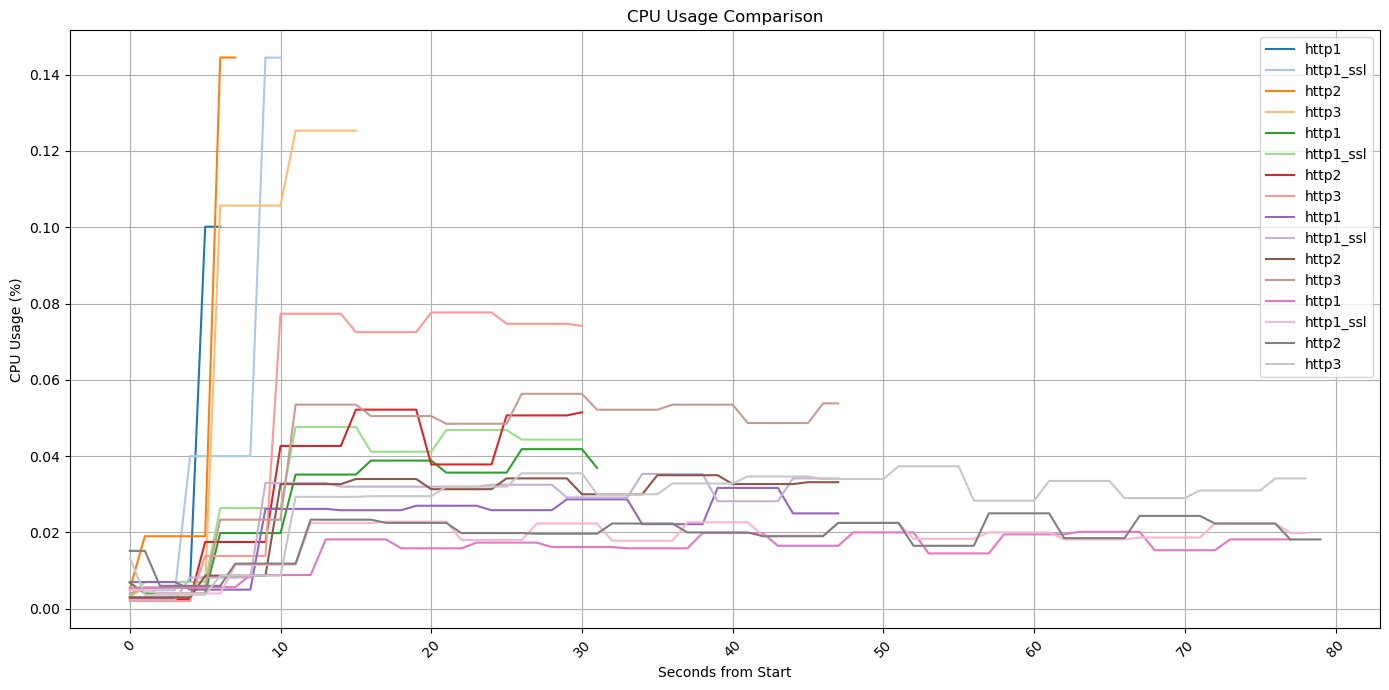

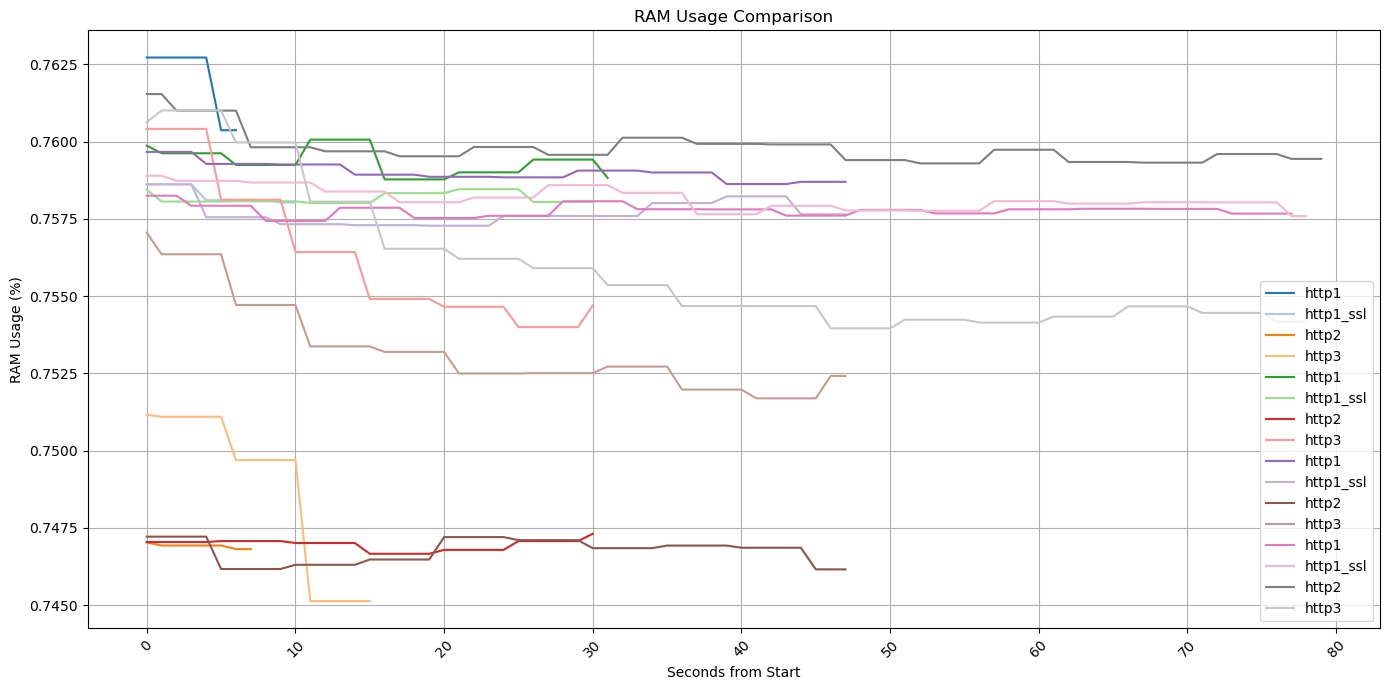

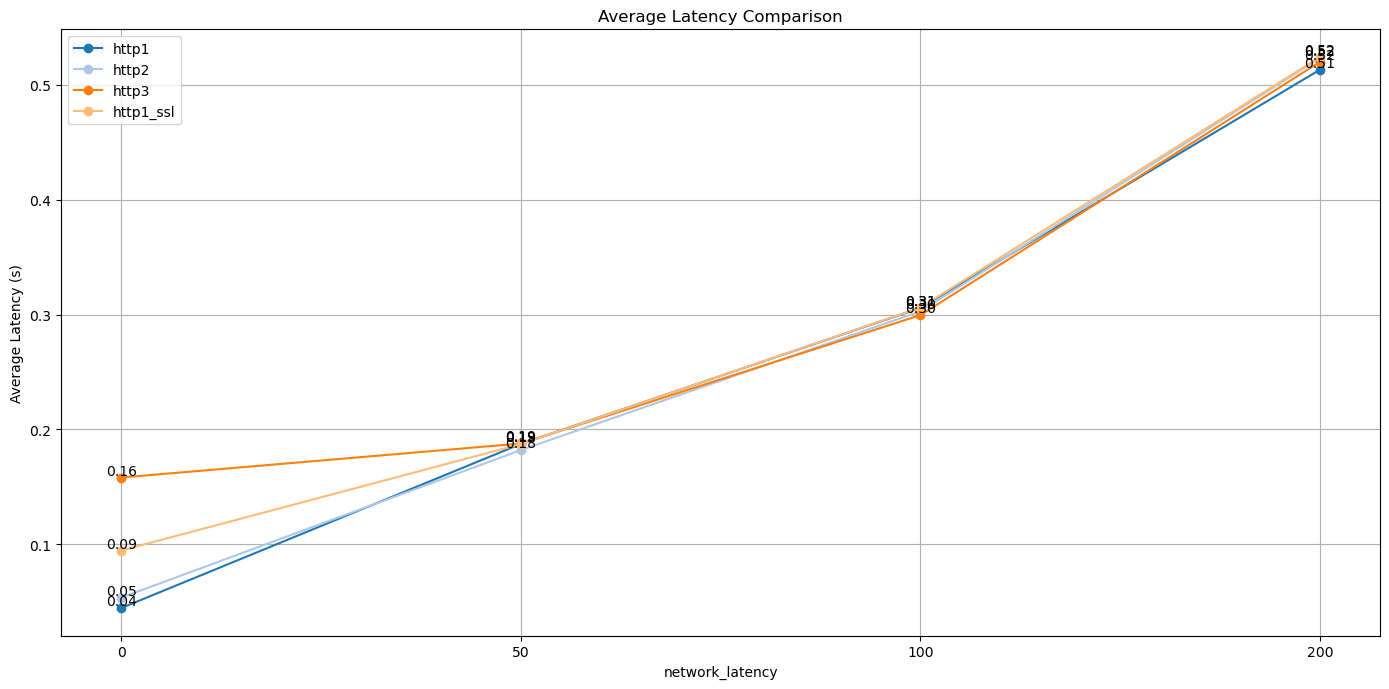

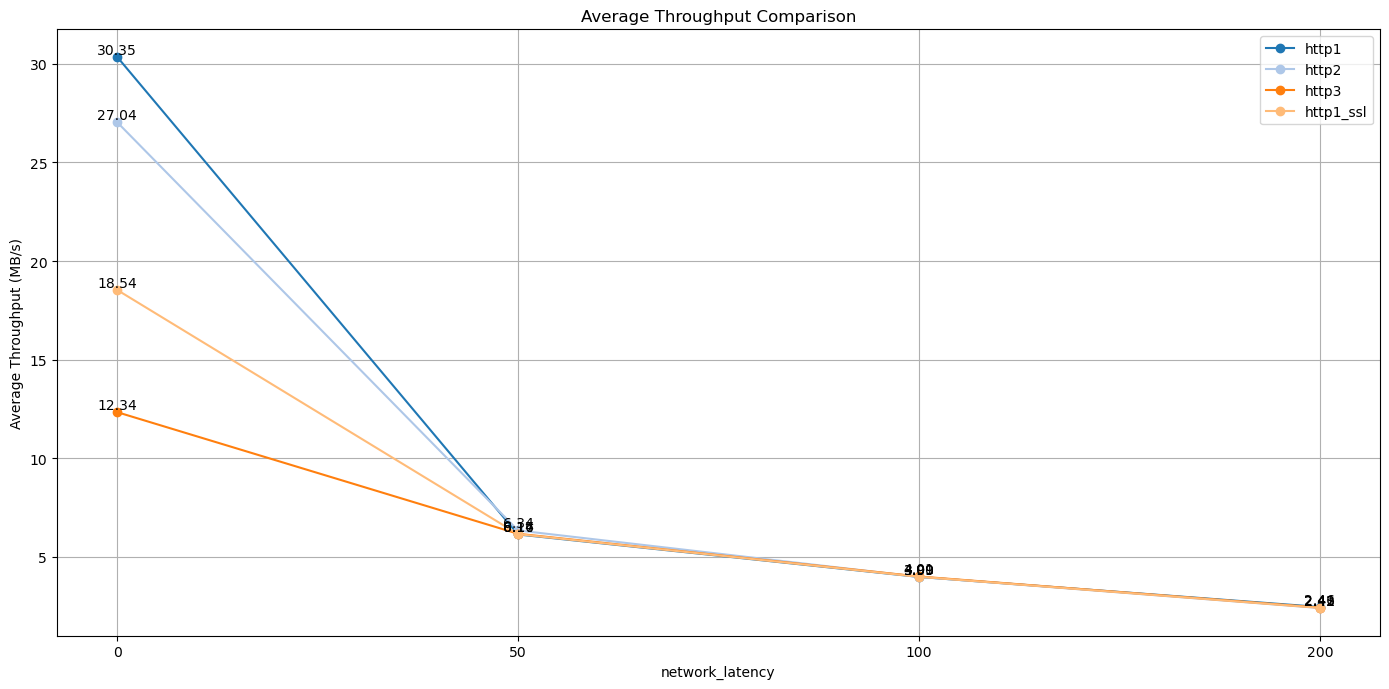

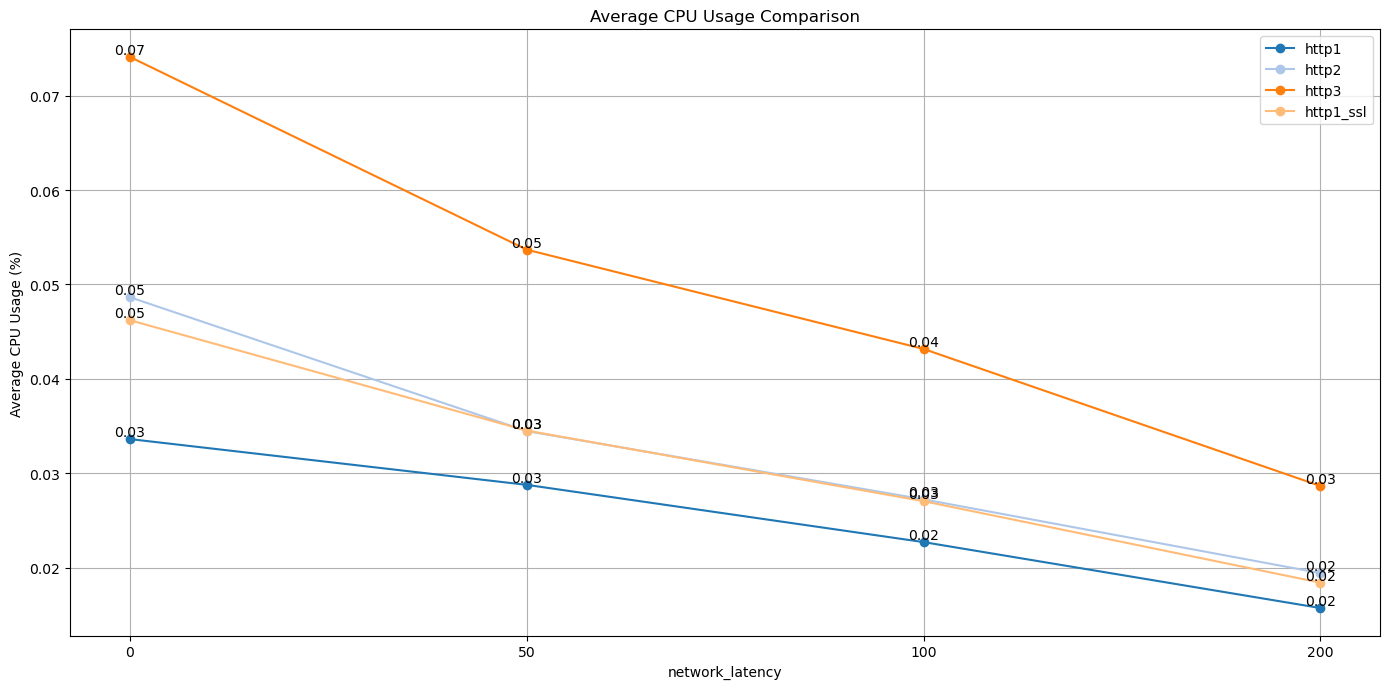

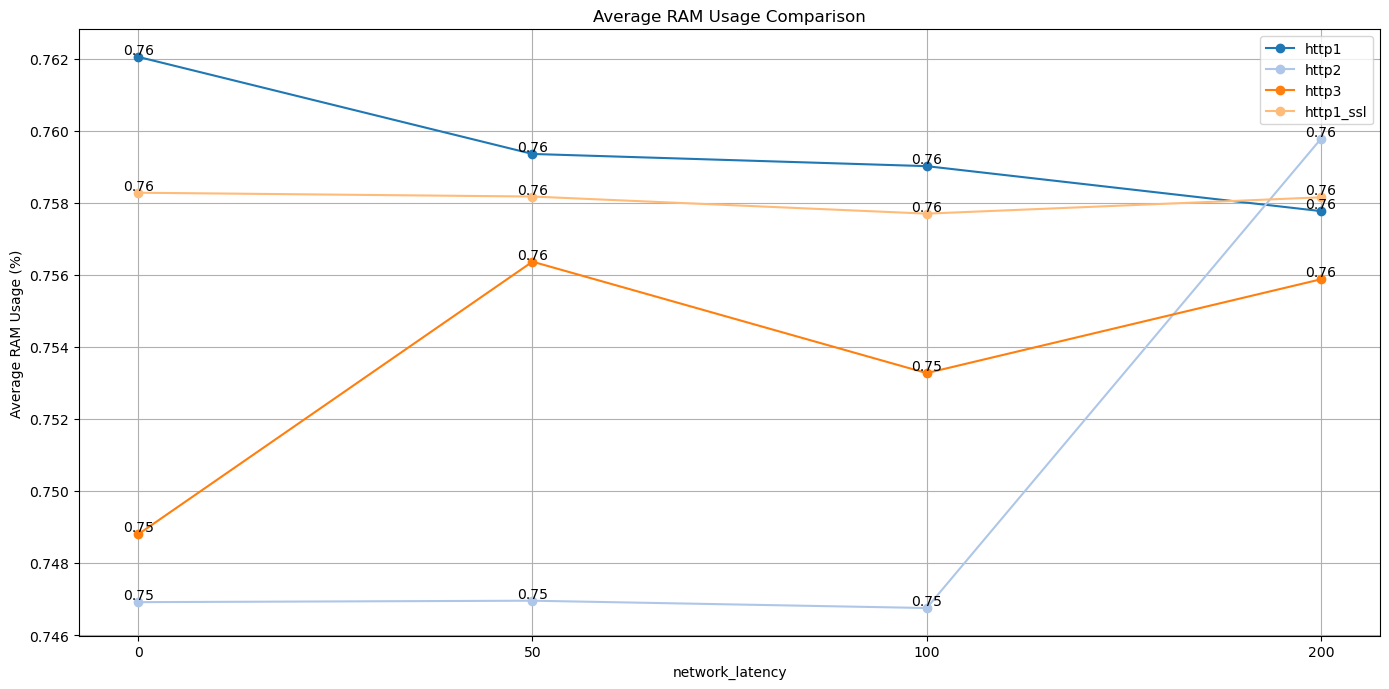

In [14]:
def main_with_network_http():
    # Constants
    data_type = "music"
      # in milliseconds
    parallel_count = 5
    num_repeats = 10

    network_latencys = [0, 50, 100, 200]
    http_versions = ["http1", "http1_ssl", "http2", "http3"]

    # Create an array of data
    test_cases = [(data_type, http_version, parallel_count, num_repeats, network_latency) for network_latency in network_latencys for http_version in http_versions]

    variable1_list = "_".join([str(lat) for lat in network_latencys])
    variable2_list = "_".join(http_versions)

    perform_comparison(test_cases, 'network_latency', 'http_version', variable1_list, variable2_list)

if __name__ == "__main__":
    main_with_network_http()